## Imports

In [166]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from pprint import pprint 
import scipy
import seaborn as sns
import pandas as pd
import csv
import os

## Files

In [167]:
spike_dataset = "M1U" # edit as necessary
r2_dir = '../Results/' # Where R2 results are stored
cycle_path = "../spikesByCycle/" # Where spikesByCycle results are stored

In [168]:
files = next(os.walk(r2_dir))[2]
files = [f for f in files if spike_dataset in f and 'Br' not in f]

## Organize Data

In [169]:
dataset = ["RyCon", "RyNb", "YeCon", "YeNb"]
marker_regions = ['Anterior', 'Intermediate', 'Posterior', 'Superficial', 'Deep']
xyz = ['X', 'Y', 'Z']

In [170]:
raw_data = defaultdict(dict)
for f in files:
    curr_file = pd.read_csv(r2_dir + '/' + f)
    name = f.split('.')[0]

    column_names = list(curr_file.columns[1:])
    r2s = {cn.strip() : float(curr_file[cn].values) for cn in column_names}
    for d in dataset:
        if d in name:
            region = name.split('_')[2]
            raw_data[d][region] = r2s

In [171]:
def XYZ(markers):
    data = {
        'X': np.asarray([markers[i] for i in range(0, len(markers), 3)], dtype=float),
        'Y': np.asarray([markers[i + 1] for i in range(0, len(markers), 3)], dtype=float),
        'Z': np.asarray([markers[i + 2] for i in range(0, len(markers), 3)], dtype=float),
    }
    return data

def cat_XYZ(*args):
    data = {
        'X': np.concatenate(([arg['X'] for arg in args])).astype(float),
        'Y': np.concatenate(([arg['Y'] for arg in args])).astype(float),
        'Z': np.concatenate(([arg['Z'] for arg in args])).astype(float),
    }
    return data

region_xyz = defaultdict(dict)
for d in dataset:
    for mr in marker_regions:
        values = list(raw_data[d][mr].values())
        region_xyz[d][mr] = XYZ(values)

data_xyz = {}
for d in dataset:
    relevant = list(region_xyz[d].values())
    data_xyz[d] = cat_XYZ(*relevant)

## Heat Map

In [172]:
def get_frame(regions, features, data):
    feature = []
    region = []
    values = []
    for r in regions:
        for i in range(3):
            region.append(r)
        feature.append(features[0])
        feature.append(features[1])
        feature.append(features[2])
    for d in data:
        values.append(np.mean(d['X']))
        values.append(np.mean(d['Y']))
        values.append(np.mean(d['Z']))
    dict = {
        'Axis': feature,
        'Region': region,
        'Values': values
    }

    return pd.DataFrame(dict)

In [173]:
def heatmap(frame_c, frame_nb, title):
    heatmap_c = frame_c.pivot(columns='Axis',index='Region', values='Values')
    heatmap_nb = frame_nb.pivot(columns='Axis',index='Region', values='Values')

    plt.figure(figsize=(8, 4))
    plt.suptitle(title)
    plt.subplot(1, 2, 1)
    plt.title('Control')
    sns.heatmap(heatmap_c, vmin = 0, vmax = 1, annot=True, cmap='inferno')
    plt.subplot(1, 2, 2)
    plt.title('Nerve Block')
    sns.heatmap(heatmap_nb, vmin = 0, vmax = 1, annot=True, cmap='inferno')
    plt.show()

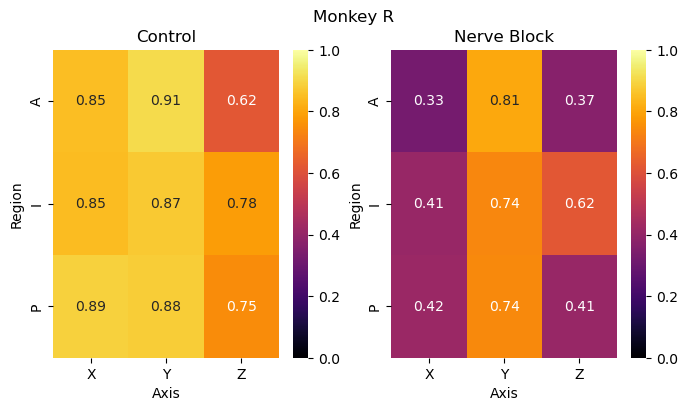

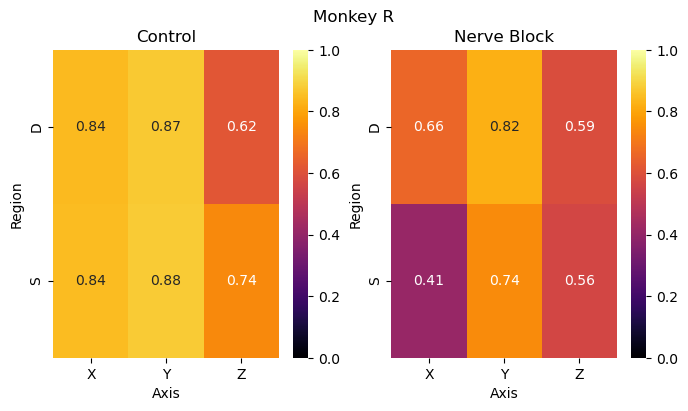

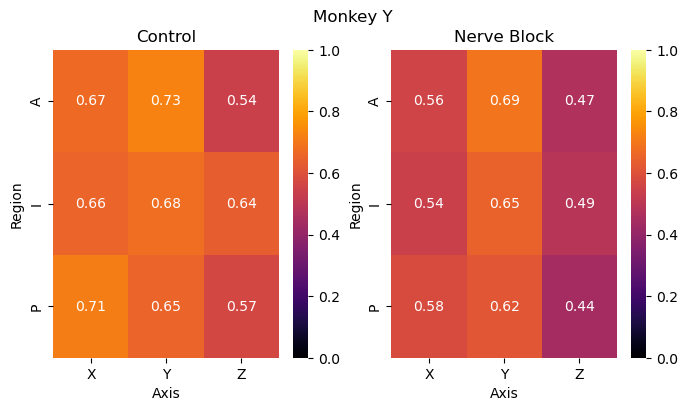

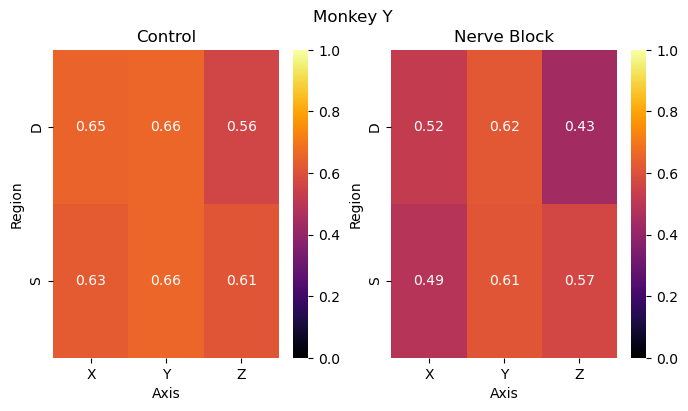

In [174]:
frames = {}
region = ['A', 'I', 'P']
depth = ['S', 'D']

for d in dataset:
    frames[d + ' Region'] = get_frame(region, xyz, [region_xyz[d]['Anterior'], region_xyz[d]['Intermediate'], region_xyz[d]['Posterior']])
    frames[d + ' Depth'] = get_frame(depth, xyz, [region_xyz[d]['Superficial'], region_xyz[d]['Deep']])

heatmap(frames['RyCon Region'], frames['RyNb Region'], 'Monkey R')
heatmap(frames['RyCon Depth'], frames['RyNb Depth'], 'Monkey R')
heatmap(frames['YeCon Region'], frames['YeNb Region'], 'Monkey Y')
heatmap(frames['YeCon Depth'], frames['YeNb Depth'], 'Monkey Y')

## Spike Histogram

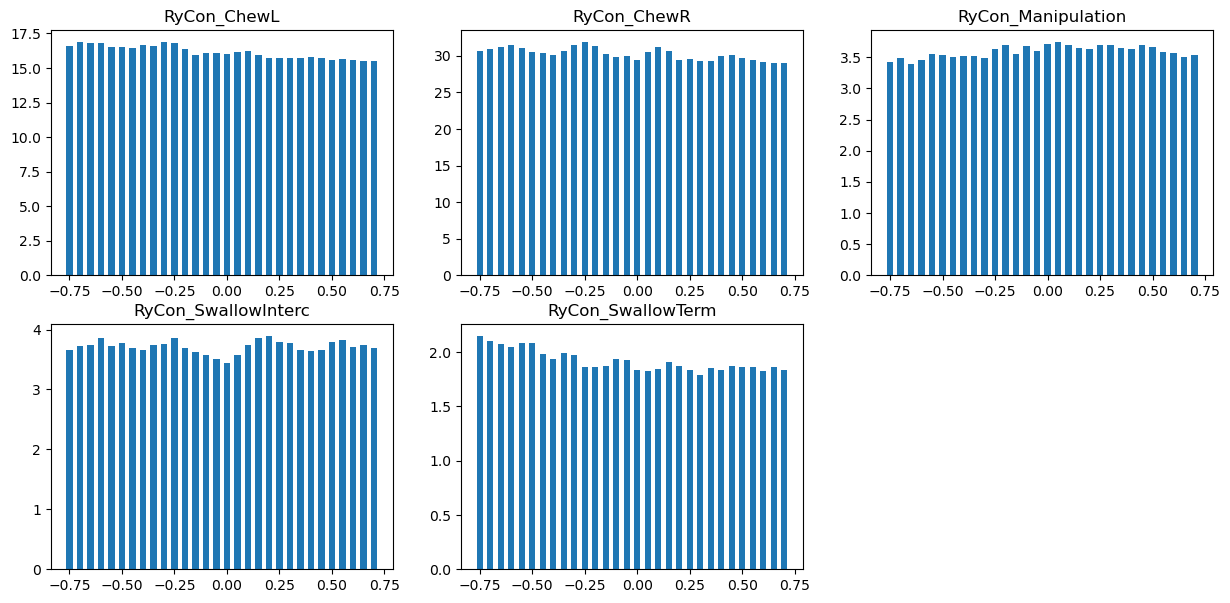

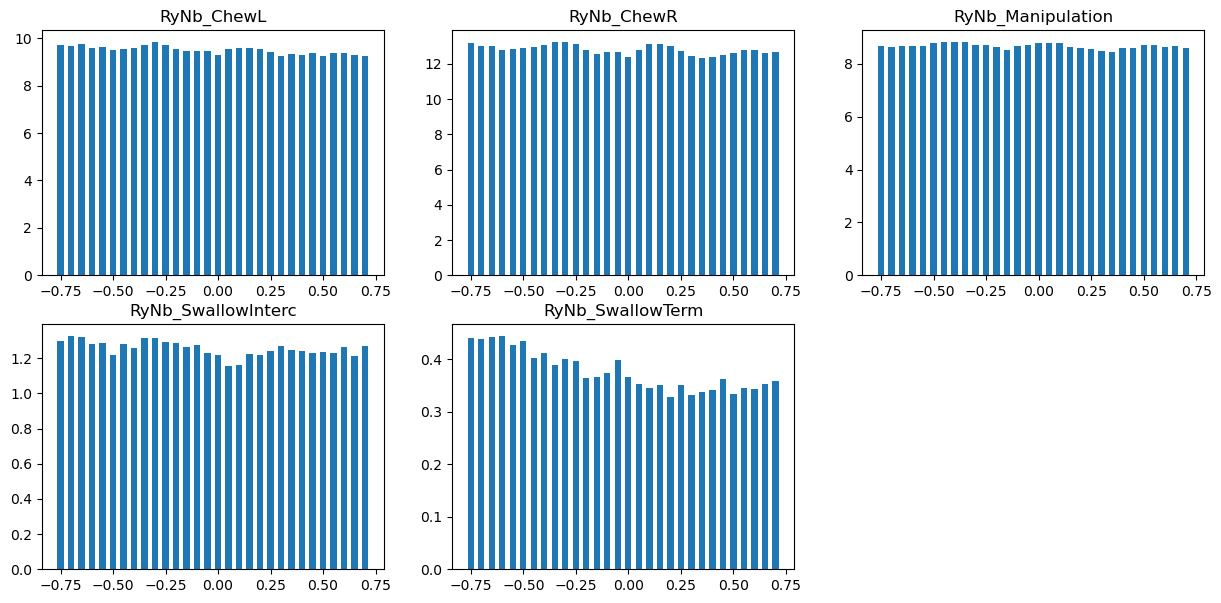

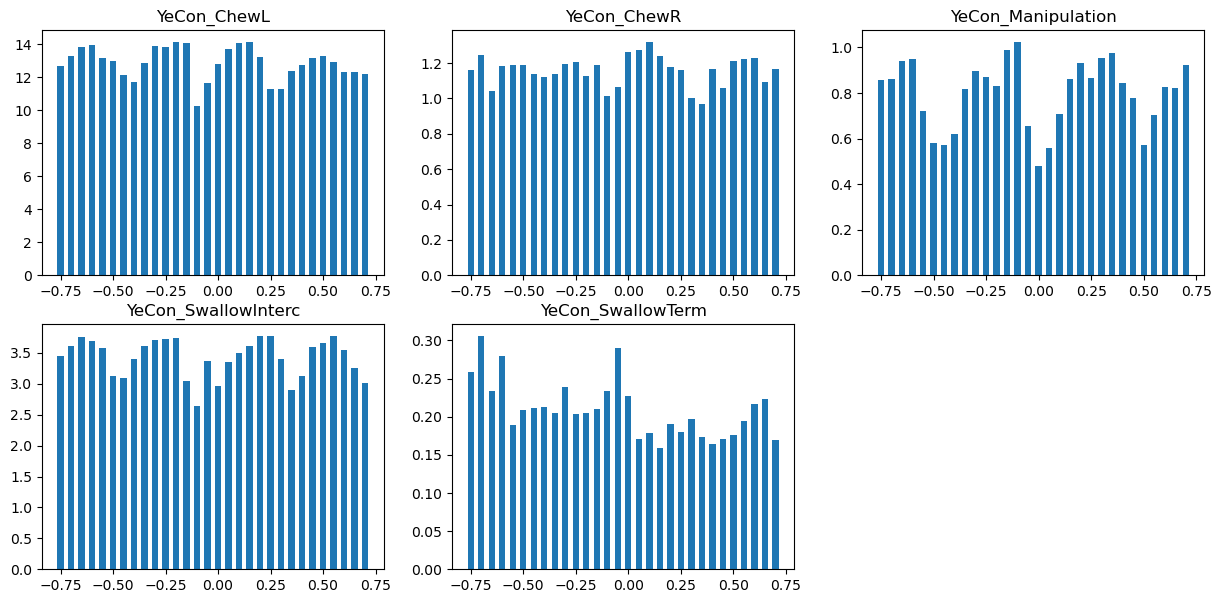

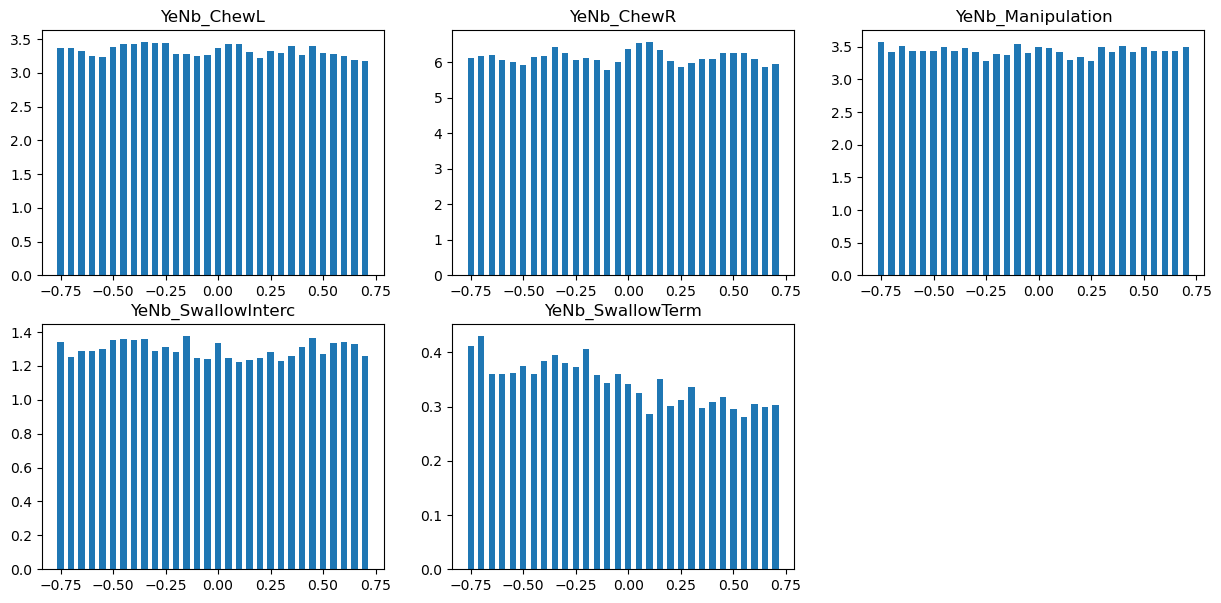

In [175]:
cycles = ["ChewL", "ChewR", "Manipulation", "SwallowInterc", "SwallowTerm"]

def test_cycle(data, cycle):
    if data["cycleType"] != cycle.lower():
        print("Expected: ", cycle)
        print("Real: ", data["cycleType"])
    return

for d_i, d in enumerate(dataset):
    plt.figure(figsize=(15, 7))
    for c_i, c in enumerate(cycles):
        cycle_data = scipy.io.loadmat(cycle_path + d + "_" + c)
        test_cycle(cycle_data, c)
        
        input = None
        neurons = [str(s).split()[1] for s in cycle_data["snrs"][spike_dataset.lower()][0, 0]]
        num_neurons = len(neurons)
        for i, neuron in enumerate(neurons):
            neuron_spikes = cycle_data["spikesByGapeCycle"][spike_dataset.lower()][0, 0][neuron]
            for j in range(neuron_spikes.shape[1]):
                extracted = np.squeeze(neuron_spikes[0, j][0, 0][0], axis=1)
                input = extracted if i == 0 and j == 0 else np.concatenate((input, extracted))
        
        plt.subplot(2, 3, c_i + 1)
        plt.title(d + "_" + c)
        y, x = np.histogram(input, bins=30)
        plt.bar(x[:-1], y / (num_neurons * 20), width=0.03)
    plt.show()  

## Percent Decrease (Post-Nerve Block)

In [176]:
def avg_pctdec(c, nb):
    diff = np.subtract(c, nb)
    div = diff / c
    return np.mean(div) * 100

def plot_pctdec(rc, rnb, yc, ynb):
    colors = ['blue', 'orange', 'green']
    rocky = []
    yosemite = []
    for i in range(len(xyz)):
        rocky.append(avg_pctdec(rc[xyz[i]], rnb[xyz[i]]))
        yosemite.append(avg_pctdec(yc[xyz[i]], ynb[xyz[i]]))

    plt.figure()
    plt.subplot(1, 2, 1)
    plt.title('Monkey R')
    plt.ylabel('Average Decoding Performance Degradation')
    plt.ylim(0, 100)
    plt.bar(xyz, rocky, color=colors)

    plt.subplot(1, 2, 2)
    plt.title('Monkey Y')
    plt.ylim(0, 100)
    plt.bar(xyz, yosemite, color=colors)

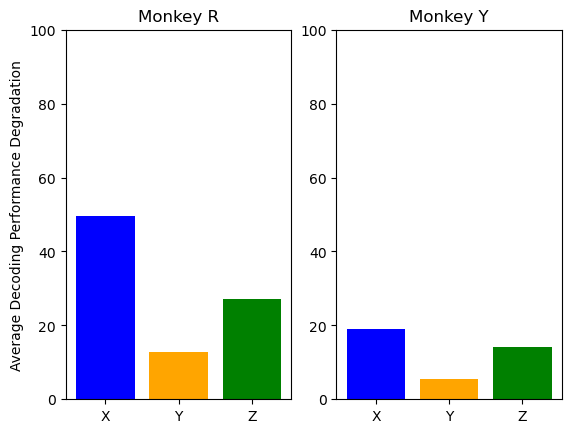

In [177]:
plot_pctdec(*[data_xyz[d] for d in dataset])

## Statistical Analysis

In [178]:
def print_stats(title, *datasets):
    if len(datasets) > 2:
        stat, p = scipy.stats.kruskal(*datasets)
    else:
        stat, p = scipy.stats.mannwhitneyu(*datasets)
    mult = ''
    if p < 0.05 and len(datasets) > 2:
        mult = scipy.stats.tukey_hsd(*datasets)
    elif p < 0.05:
        mult = 'Significant'

    print(title)
    print()
    print('H Statistic: ' + str(stat))
    print('P-Value: ' + str(p))
    if mult != '':
        print()
        print(mult)
    print()
    return float(stat)

### Control vs. Nerve Block

In [179]:
for i in range(len(xyz)):
    print_stats('Rocky ' + xyz[i], data_xyz['RyCon'][xyz[i]], data_xyz['RyNb'][xyz[i]])

for i in range(len(xyz)):
    print_stats('Yosemite ' + xyz[i], data_xyz['YeCon'][xyz[i]], data_xyz['YeNb'][xyz[i]])

Rocky X

H Statistic: 625.0
P-Value: 1.4156562248495537e-09

Significant

Rocky Y

H Statistic: 603.0
P-Value: 1.8355518172726175e-08

Significant

Rocky Z

H Statistic: 476.0
P-Value: 0.0015633235674326375

Significant

Yosemite X

H Statistic: 565.0
P-Value: 1.0108307687115281e-06

Significant

Yosemite Y

H Statistic: 410.0
P-Value: 0.059825636317548045

Yosemite Z

H Statistic: 478.0
P-Value: 0.001367281930175315

Significant



### Across Regions

In [180]:
print('Anterior vs. Intermediate vs. Posterior')
print()
for d in dataset:
    print(d)
    print()
    for i in range(len(xyz)):
        print_stats(xyz[i], region_xyz[d]['Anterior'][xyz[i]], region_xyz[d]['Intermediate'][xyz[i]], region_xyz[d]['Posterior'][xyz[i]])

Anterior vs. Intermediate vs. Posterior

RyCon

X

H Statistic: 5.56964285714286
P-Value: 0.061740113066831005

Y

H Statistic: 2.3767857142857167
P-Value: 0.3047105841965928

Z

H Statistic: 4.0535714285714235
P-Value: 0.13175835022057947

RyNb

X

H Statistic: 0.6625000000000014
P-Value: 0.7180256401903509

Y

H Statistic: 10.5
P-Value: 0.0052475183991813855

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)      0.070     0.003     0.025     0.116
 (0 - 2)      0.068     0.005     0.022     0.113
 (1 - 0)     -0.070     0.003    -0.116    -0.025
 (1 - 2)     -0.003     0.988    -0.054     0.048
 (2 - 0)     -0.068     0.005    -0.113    -0.022
 (2 - 1)      0.003     0.988    -0.048     0.054


Z

H Statistic: 2.891071428571429
P-Value: 0.23561981783717065

YeCon

X

H Statistic: 2.0821428571428555
P-Value: 0.3530761833171625

Y

H Statistic: 2.8500000000000014
P-Value: 0.240508463208342

Z

H Statistic: 1.

In [181]:
print('Superficial vs. Deep')
print()
for d in dataset:
    print(d)
    print()
    for i in range(len(xyz)):
        print_stats(xyz[i], region_xyz[d]['Superficial'][xyz[i]], region_xyz[d]['Deep'][xyz[i]])

Superficial vs. Deep

RyCon

X

H Statistic: 12.0
P-Value: 1.0

Y

H Statistic: 12.0
P-Value: 1.0

Z

H Statistic: 19.0
P-Value: 0.17142857142857143

RyNb

X

H Statistic: 3.0
P-Value: 0.06666666666666667

Y

H Statistic: 4.0
P-Value: 0.11428571428571428

Z

H Statistic: 12.0
P-Value: 1.0

YeCon

X

H Statistic: 8.0
P-Value: 0.47619047619047616

Y

H Statistic: 11.0
P-Value: 0.9142857142857143

Z

H Statistic: 16.0
P-Value: 0.47619047619047616

YeNb

X

H Statistic: 6.0
P-Value: 0.2571428571428571

Y

H Statistic: 11.0
P-Value: 0.9142857142857143

Z

H Statistic: 22.0
P-Value: 0.0380952380952381

Significant



### Across Axes of Motion

In [182]:
print('X vs. Y vs. Z')
print()
for d in dataset:
    print(d)
    print()
    print_stats('Anterior', region_xyz[d]['Anterior']['X'], region_xyz[d]['Anterior']['Y'], region_xyz[d]['Anterior']['Z'])
    print_stats('Intermediate', region_xyz[d]['Intermediate']['X'], region_xyz[d]['Intermediate']['Y'], region_xyz[d]['Intermediate']['Z'])
    print_stats('Posterior', region_xyz[d]['Posterior']['X'], region_xyz[d]['Posterior']['Y'], region_xyz[d]['Posterior']['Z'])

X vs. Y vs. Z

RyCon

Anterior

H Statistic: 16.48237476808906
P-Value: 0.0002635711034563854

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)     -0.059     0.411    -0.174     0.056
 (0 - 2)      0.229     0.000     0.114     0.345
 (1 - 0)      0.059     0.411    -0.056     0.174
 (1 - 2)      0.288     0.000     0.173     0.404
 (2 - 0)     -0.229     0.000    -0.345    -0.114
 (2 - 1)     -0.288     0.000    -0.404    -0.173


Intermediate

H Statistic: 2.923076923076927
P-Value: 0.23187926284819185

Posterior

H Statistic: 7.384615384615387
P-Value: 0.024914440787632705

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)      0.008     0.956    -0.071     0.087
 (0 - 2)      0.141     0.002     0.062     0.220
 (1 - 0)     -0.008     0.956    -0.087     0.071
 (1 - 2)      0.133     0.003     0.054     0.212
 (2 - 0)     -0.141

In [183]:
print('X vs. Y vs. Z')
print()
for d in dataset:
    print(d)
    print()
    print_stats('Superficial', region_xyz[d]['Superficial']['X'], region_xyz[d]['Superficial']['Y'], region_xyz[d]['Superficial']['Z'])
    print_stats('Deep', region_xyz[d]['Deep']['X'], region_xyz[d]['Deep']['Y'], region_xyz[d]['Deep']['Z'])

X vs. Y vs. Z

RyCon

Superficial

H Statistic: 6.771929824561411
P-Value: 0.033844969158448465

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)     -0.033     0.828    -0.176     0.111
 (0 - 2)      0.103     0.186    -0.041     0.246
 (1 - 0)      0.033     0.828    -0.111     0.176
 (1 - 2)      0.135     0.067    -0.009     0.279
 (2 - 0)     -0.103     0.186    -0.246     0.041
 (2 - 1)     -0.135     0.067    -0.279     0.009


Deep

H Statistic: 7.7307692307692335
P-Value: 0.020954861324889128

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)     -0.030     0.846    -0.180     0.120
 (0 - 2)      0.226     0.006     0.076     0.376
 (1 - 0)      0.030     0.846    -0.120     0.180
 (1 - 2)      0.256     0.003     0.106     0.406
 (2 - 0)     -0.226     0.006    -0.376    -0.076
 (2 - 1)     -0.256     0.003    -0.406    -0.